In [86]:
import arch
print(arch.__version__)


5.3.1


In [166]:
import os
import pandas as pd
import numpy as np
from _datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [15]:
# read csv

binance = pd.read_csv('/Users/wanjinwoo/Desktop/Antalpha/Github/data/binance.csv', sep=',')
binance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8090 entries, 0 to 8089
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            8090 non-null   object 
 1   open            8090 non-null   float64
 2   high            8090 non-null   float64
 3   low             8090 non-null   float64
 4   close           8090 non-null   float64
 5   volume          8090 non-null   float64
 6   adjusted_close  8090 non-null   float64
 7   tic             8090 non-null   object 
dtypes: float64(6), object(2)
memory usage: 505.8+ KB


In [16]:
binance

,time,open,high,low,close,volume,adjusted_close,tic
0,2018-01-01 08:00:00,733.0100,763.5500,716.8000,754.9900,5.390926e+04,754.9900,ETHUSDT
1,2018-01-02 08:00:00,754.9900,899.5000,749.0600,855.2800,1.132578e+05,855.2800,ETHUSDT
2,2018-01-03 08:00:00,855.1300,950.0100,810.0000,934.0300,8.904146e+04,934.0300,ETHUSDT
3,2018-01-04 08:00:00,934.0300,1009.7200,890.0100,940.0000,1.028945e+05,940.0000,ETHUSDT
4,2018-01-05 08:00:00,940.0000,1045.0000,930.0000,959.3000,9.737402e+04,959.3000,ETHUSDT
...,...,...,...,...,...,...,...,...
8085,2022-12-25 08:00:00,0.7956,0.7991,0.7853,0.7950,2.148862e+07,0.7950,MATICUSDT
8086,2022-12-26 08:00:00,0.7952,0.8168,0.7936,0.8154,2.756270e+07,0.8154,MATICUSDT
8087,2022-12-27 08:00:00,0.8154,0.8196,0.7973,0.8063,3.692406e+07,0.8063,MATICUSDT
8088,2022-12-28 08:00:00,0.8064,0.8085,0.7750,0.7827,5.066738e+07,0.7827,MATICUSDT


In [60]:
# 用volume算出各个币的权重得到一个weights by月份
binance['month'] = binance['time'].str[:7]
binance['trading_volume'] = binance['volume'] * binance['adjusted_close']


,time,open,high,low,close,volume,adjusted_close,tic,month,trading_volume
0,2018-01-01 08:00:00,733.0100,763.5500,716.8000,754.9900,5.390926e+04,754.9900,ETHUSDT,2018-01,4.070095e+07
1,2018-01-02 08:00:00,754.9900,899.5000,749.0600,855.2800,1.132578e+05,855.2800,ETHUSDT,2018-01,9.686712e+07
2,2018-01-03 08:00:00,855.1300,950.0100,810.0000,934.0300,8.904146e+04,934.0300,ETHUSDT,2018-01,8.316739e+07
3,2018-01-04 08:00:00,934.0300,1009.7200,890.0100,940.0000,1.028945e+05,940.0000,ETHUSDT,2018-01,9.672081e+07
4,2018-01-05 08:00:00,940.0000,1045.0000,930.0000,959.3000,9.737402e+04,959.3000,ETHUSDT,2018-01,9.341089e+07
...,...,...,...,...,...,...,...,...,...,...
8085,2022-12-25 08:00:00,0.7956,0.7991,0.7853,0.7950,2.148862e+07,0.7950,MATICUSDT,2022-12,1.708345e+07
8086,2022-12-26 08:00:00,0.7952,0.8168,0.7936,0.8154,2.756270e+07,0.8154,MATICUSDT,2022-12,2.247462e+07
8087,2022-12-27 08:00:00,0.8154,0.8196,0.7973,0.8063,3.692406e+07,0.8063,MATICUSDT,2022-12,2.977187e+07
8088,2022-12-28 08:00:00,0.8064,0.8085,0.7750,0.7827,5.066738e+07,0.7827,MATICUSDT,2022-12,3.965736e+07


In [61]:
# aggregate by month
volume_month = binance.groupby(['tic', 'month']).agg({'trading_volume': ['sum']}).reset_index().rename(columns={'trading_volume': 'volume_coin_month'})
volume_month.columns = [col[0] if col[1]=='' else col[0] for col in volume_month.columns]
volume_month['sqrt_vol_coin'] = np.sqrt(volume_month['volume_coin_month'])

In [65]:
volume_month_tot = volume_month.groupby(['month']).agg({'sqrt_vol_coin': ['sum']}).reset_index().rename(columns={'sqrt_vol_coin': 'sqrt_vol_tot'})

volume_month_tot.columns = [col[0] if col[1]=='' else col[0] for col in volume_month_tot.columns]

In [99]:
weights = pd.merge(volume_month, volume_month_tot, on='month', how='left')
weights['weight'] = weights['sqrt_vol_coin']/weights['sqrt_vol_tot']
weights

,tic,month,volume_coin_month,sqrt_vol_coin,sqrt_vol_tot,weight
0,BNBUSDT,2018-01,1.199623e+09,34635.569675,204166.742095,0.169644
1,BNBUSDT,2018-02,6.298474e+08,25096.760259,196457.406718,0.127747
2,BNBUSDT,2018-03,1.127731e+09,33581.710460,179918.477031,0.186650
3,BNBUSDT,2018-04,1.444442e+09,38005.818951,178945.060205,0.212388
4,BNBUSDT,2018-05,8.309669e+08,28826.496596,171403.317834,0.168179
...,...,...,...,...,...,...
262,MATICUSDT,2022-08,2.049688e+09,45273.484370,729447.062913,0.062065
263,MATICUSDT,2022-09,1.671311e+09,40881.669226,755591.561474,0.054106
264,MATICUSDT,2022-10,1.573278e+09,39664.566864,704786.910507,0.056279
265,MATICUSDT,2022-11,4.557729e+09,67510.953913,817572.290663,0.082575


In [100]:
# check if reasonable
weights.groupby(['tic']).agg({'weight': ['mean']})


,weight
,mean
tic,
BNBUSDT,0.153900
BTCUSDT,0.461748
DOGEUSDT,0.076890
ETHUSDT,0.276183
MATICUSDT,0.072461


In [105]:
# 把weights merge回by day原数据
weights_day = pd.merge(binance,weights, on=['tic','month'],how='outer', indicator = False)


In [145]:
weights_wide = weights_day[['time','tic','weight']].pivot(index='time', columns='tic', values='weight').fillna(0)
weights_wide.columns = ['BNB', 'BTC','DOGE','ETH','MATIC']
weights_wide

,BNB,BTC,DOGE,ETH,MATIC
time,,,,,
2018-01-01 08:00:00,0.169644,0.491648,0.000000,0.338708,0.000000
2018-01-02 08:00:00,0.169644,0.491648,0.000000,0.338708,0.000000
2018-01-03 08:00:00,0.169644,0.491648,0.000000,0.338708,0.000000
2018-01-04 08:00:00,0.169644,0.491648,0.000000,0.338708,0.000000
2018-01-05 08:00:00,0.169644,0.491648,0.000000,0.338708,0.000000
...,...,...,...,...,...
2022-12-25 08:00:00,0.094470,0.544139,0.098047,0.198496,0.064849
2022-12-26 08:00:00,0.094470,0.544139,0.098047,0.198496,0.064849
2022-12-27 08:00:00,0.094470,0.544139,0.098047,0.198496,0.064849


In [125]:
# 2. 计算return
returns = pd.read_csv('/Users/wanjinwoo/Desktop/Antalpha/Github/data/coins_price.csv', sep=',')

returns[['BNB_r', 'BTC_r','DOGE_r','ETH_r','MATIC_r']] = returns[['BNBUSDT', 'BTCUSDT','DOGEUSDT','ETHUSDT','MATICUSDT']].apply(lambda x: np.log(x) - np.log(x.shift(1)))


,time,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,MATICUSDT
0,2018-01-01 08:00:00,8.4500,13380.00,NaN,754.99,NaN
1,2018-01-02 08:00:00,8.7150,14675.11,NaN,855.28,NaN
2,2018-01-03 08:00:00,9.3040,14919.51,NaN,934.03,NaN
3,2018-01-04 08:00:00,9.1430,15059.54,NaN,940.00,NaN
4,2018-01-05 08:00:00,14.8908,16960.39,NaN,959.30,NaN
...,...,...,...,...,...,...
1819,2022-12-25 08:00:00,243.2000,16832.11,0.07598,1218.51,0.7950
1820,2022-12-26 08:00:00,244.3000,16919.39,0.07568,1228.11,0.8154
1821,2022-12-27 08:00:00,246.7000,16706.36,0.07372,1211.55,0.8063
1822,2022-12-28 08:00:00,244.5000,16547.31,0.07040,1190.15,0.7827


In [147]:

variance = returns[['BNB_r', 'BTC_r','DOGE_r','ETH_r','MATIC_r']].ewm(span=10).std() ** 2
variance.columns = ['BNB', 'BTC','DOGE','ETH','MATIC']
variance_time = returns.join(variance)[['time','BNB', 'BTC','DOGE','ETH','MATIC']].set_index('time').fillna(0)
# pd.merge(variance,weights, on=['tic','month'],how='outer', indicator = False)

In [161]:
volatility = pd.DataFrame(np.sqrt(np.diag((np.dot(variance_time,np.transpose(weights_wide))))))

volatility.columns = ['volatility']
volatility['VCRIX'] = volatility['volatility'] *10000

In [162]:
# set time index
date_range = pd.date_range(start='2018-01-01', end='2022-12-29', freq='D')
volatility = volatility.set_index(date_range)
volatility

,volatility,VCRIX
2018-01-01,0.000000,0.000000
2018-01-02,0.000000,0.000000
2018-01-03,0.041758,417.576181
2018-01-04,0.050656,506.555504
2018-01-05,0.117393,1173.929666
...,...,...
2022-12-25,0.022166,221.657974
2022-12-26,0.020436,204.358904
2022-12-27,0.019395,193.954570
2022-12-28,0.018807,188.070208


## line chart

In [168]:
# Plot settings

SCALE_FACTOR = 2

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [5 * SCALE_FACTOR, 2 * SCALE_FACTOR]
plt.rcParams['figure.dpi'] = 300 * SCALE_FACTOR
plt.rcParams['font.size'] = 5 * SCALE_FACTOR
plt.rcParams['axes.labelsize'] = 5 * SCALE_FACTOR
plt.rcParams['axes.titlesize'] = 6 * SCALE_FACTOR
plt.rcParams['xtick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['ytick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['font.family'] = 'serif'

/var/folders/lx/f8gcbnbd18x_k936zw7ddqrh0000gn/T/ipykernel_88662/3729068229.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [173]:
# btc eth
btc = pd.read_csv('/Users/wanjinwoo/Desktop/Antalpha/Github/data/btc_day.csv', sep=',')
eth = pd.read_csv('/Users/wanjinwoo/Desktop/Antalpha/Github/data/eth_day.csv', sep=',')
# convert dates to timestamp and make dates index
eth['time'] = pd.to_datetime(eth['time'])
eth.index=pd.to_datetime(eth.time)
eth.drop('time', inplace=True, axis=1)

btc['time'] = pd.to_datetime(btc['time'])
btc.index=pd.to_datetime(btc.time)
btc.drop('time', inplace=True, axis=1)

In [181]:
# log
btc_log = pd.DataFrame(np.log(btc['adjusted_close']))
eth_log = pd.DataFrame(np.log(eth['adjusted_close']))
volatility['vcrix_log'] = np.log(volatility['VCRIX'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [188]:
vola_2122 = volatility[(volatility.index >= datetime(2021, 1, 1)) ]
btc_log1 =btc_log[(btc_log.index >= datetime(2021, 1, 1))]
eth_log1 =eth_log[(eth_log.index >= datetime(2021, 1, 1))]

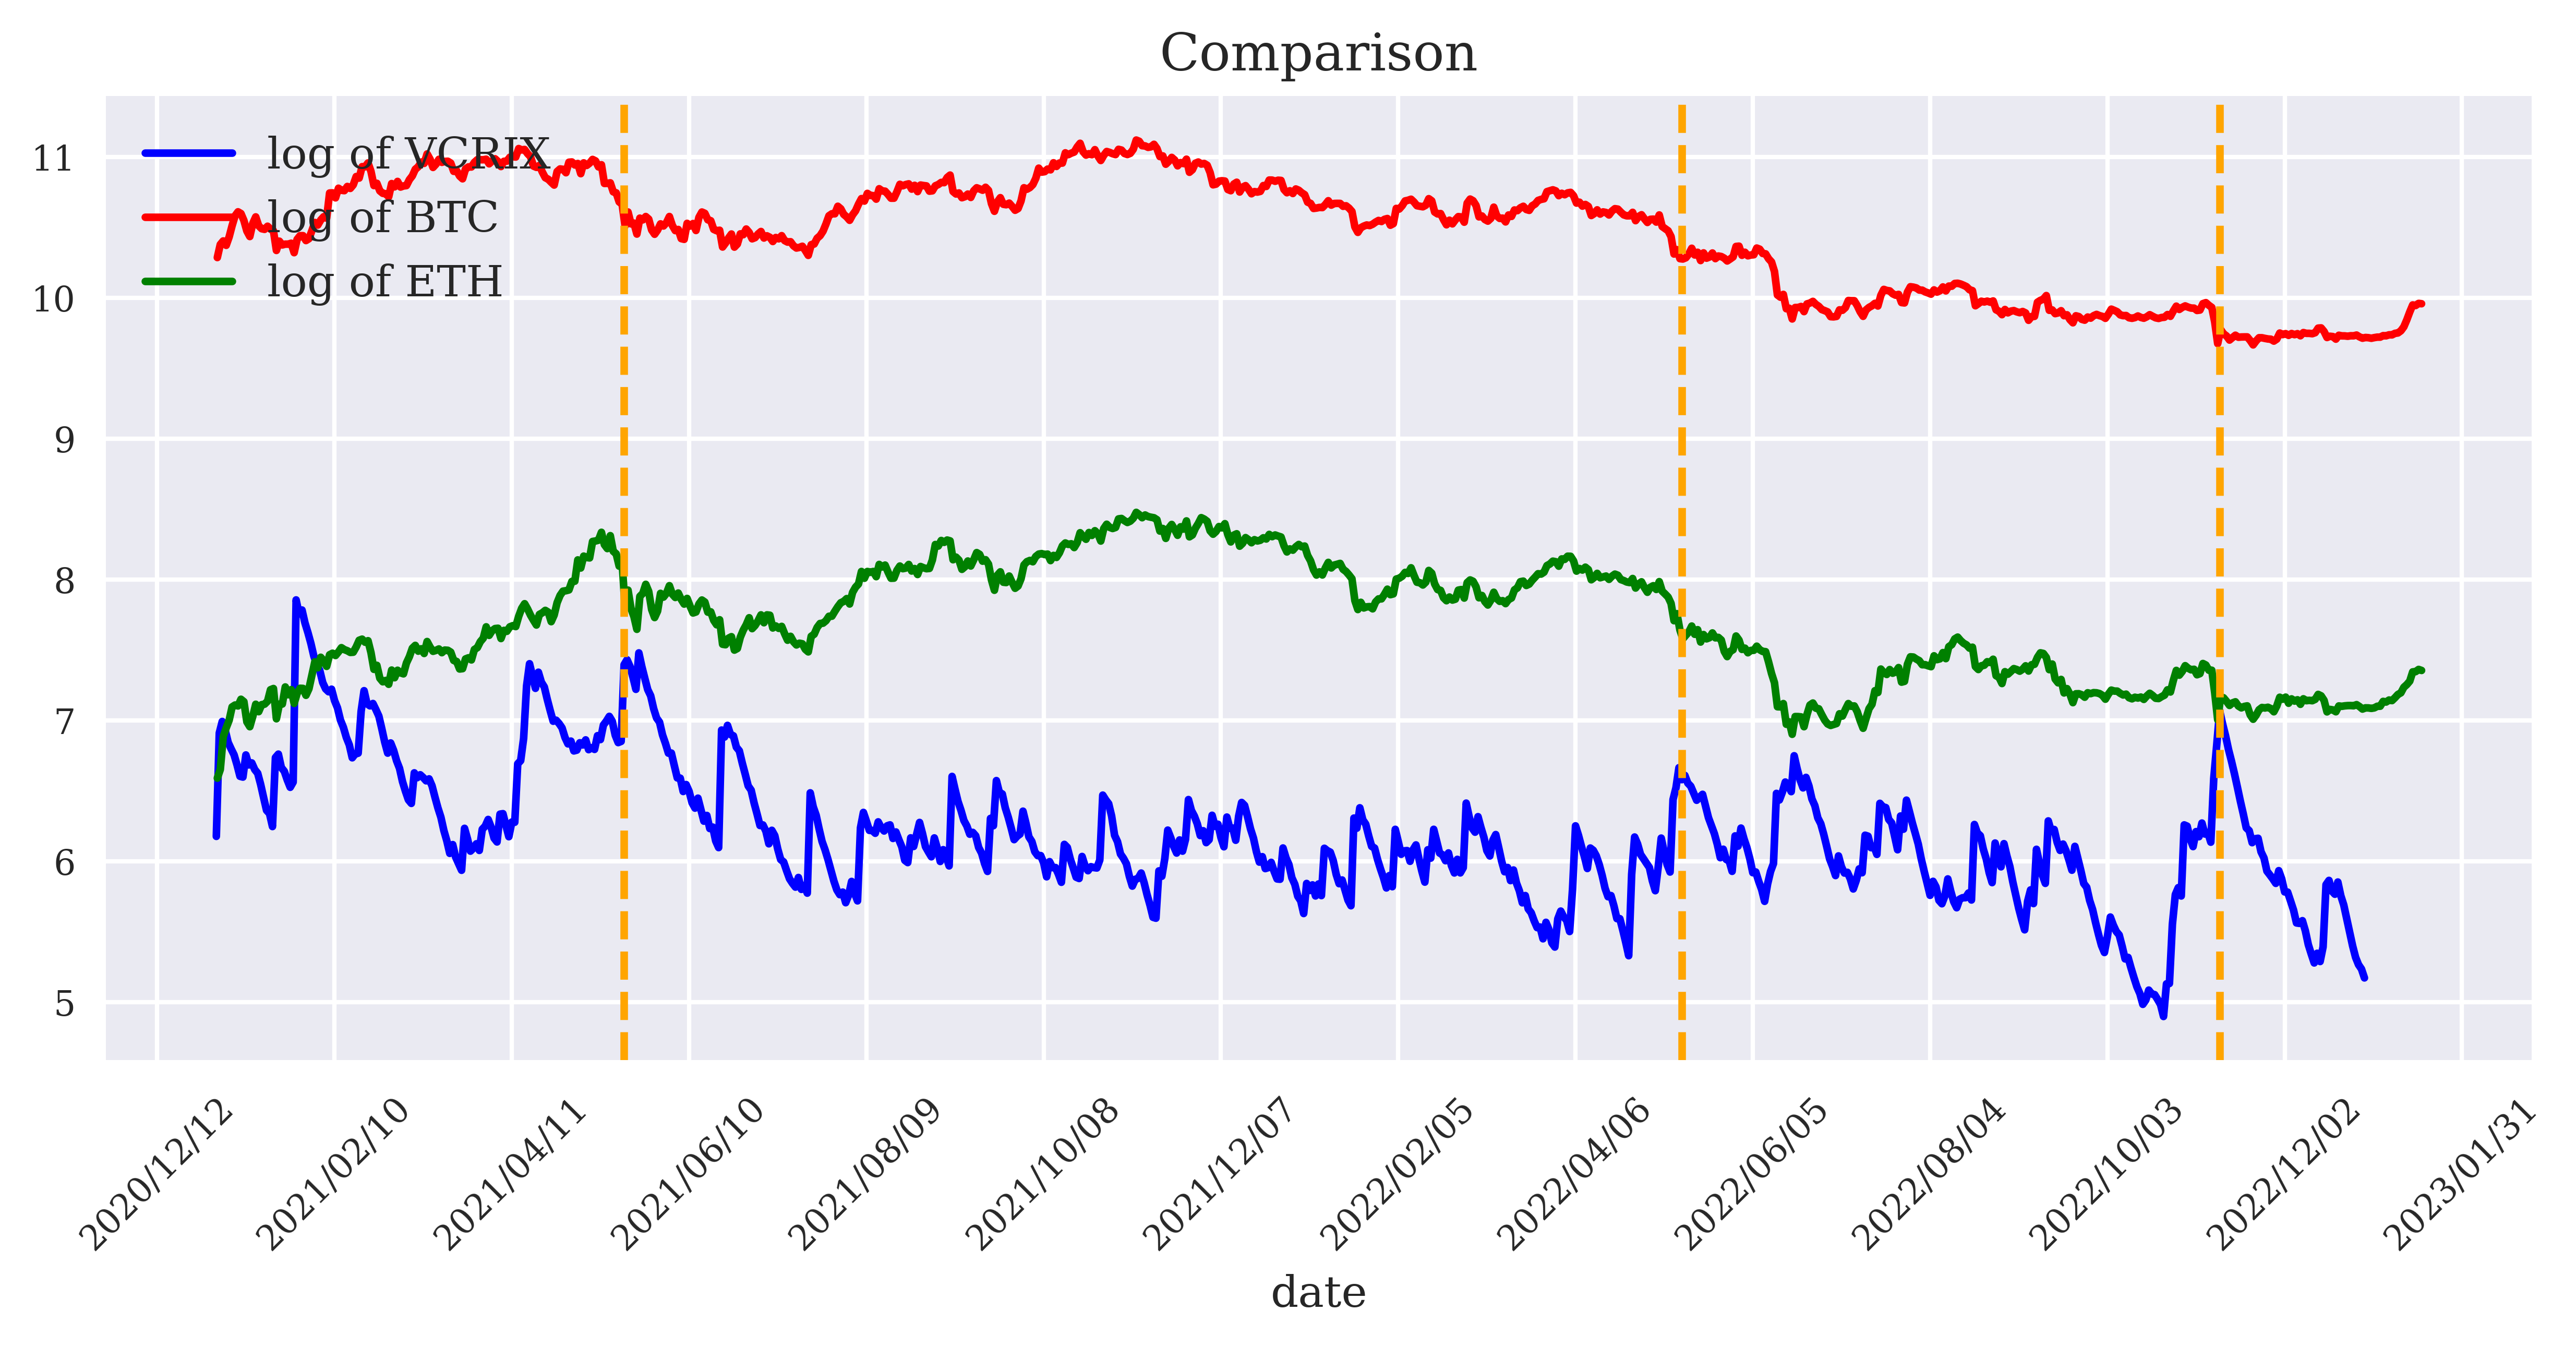

In [197]:
fig,ax = plt.subplots()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

ax.set(title='Comparison',
       xlabel='date')
ax.plot(vola_2122.vcrix_log,c='b',label='log of VCRIX')
ax.plot(btc_log1.adjusted_close,c='r',label='log of BTC')
ax.plot(eth_log1.adjusted_close,c='g',label='log of ETH') 
ax.axvline(x=datetime(2021, 5, 19), color='orange', linestyle = 'dashed')
ax.axvline(x=datetime(2022, 5, 12), color='orange', linestyle = 'dashed')
ax.axvline(x=datetime(2022, 11, 10), color='orange', linestyle = 'dashed')
plt.legend(loc=2)

## HAR model to forecast volatility
https://github.com/deep-hedger-Peng/HAR-RV/blob/master/HAR-RV_forecast.ipynb